1.LOAD THE DATA

In [1]:
import numpy as np

# Load stored data
images = np.load("UTKFaceimage.npy")  # Image data
ages = np.load("UTKFaceages.npy")  # Age labels (Regression)
genders = np.load("UTKFacegenders.npy")  # Gender labels (0 = Male, 1 = Female)

# Normalize images
images = images.astype("float32") / 255.0

# Ensure grayscale images have correct dimensions
if len(images.shape) == 3:
    images = np.expand_dims(images, axis=-1)

print(f"Images shape: {images.shape}, Ages shape: {ages.shape}, Genders shape: {genders.shape}")


Images shape: (23708, 48, 48, 3), Ages shape: (23708,), Genders shape: (23708,)


2.SPLIT THE DATA

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3.BUILD THE MODEL

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

# Define input layer
input_layer = Input(shape=X_train.shape[1:])

# **First CNN Block**
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)  # Normalize activations
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)  # Prevent overfitting

# **Second CNN Block**
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.4)(x)

# **Third CNN Block**
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.5)(x)  # Increased dropout

# **Fully Connected Layers**
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # More neurons for better feature extraction
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# **Age Output (Regression)**
age_output = layers.Dense(1, name="age_output")(x)

# **Gender Output (Classification)**
gender_output = layers.Dense(1, activation="sigmoid", name="gender_output")(x)

# **Define Model**
model = models.Model(inputs=input_layer, outputs=[age_output, gender_output])

# **Compile Model**
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for stability
    loss={"age_output": "mse", "gender_output": "binary_crossentropy"},
    metrics={"age_output": "mae", "gender_output": "accuracy"}
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 24,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    295,168 │ dropout_4[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 6, 6, 256) │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 9216)      │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  4,719,104 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,226,626 (19.94 MB)

 Trainable params: 5,224,194 (19.93 MB)

 Non-trainable params: 2,432 (9.50 KB)

4.TRAIN THE MODEL

In [9]:
history = model.fit(
    X_train, 
    {"age_output": y_age_train, "gender_output": y_gender_train},
    validation_data=(X_test, {"age_output": y_age_test, "gender_output": y_gender_test}),
    epochs=50,  # Increase epochs for better learning
    batch_size=32
)


Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 429s 711ms/step - age_output_loss: 1437.9844 - age_output_mae: 33.1699 - gender_output_accuracy: 0.5461 - gender_output_loss: 0.9229 - loss: 1438.9073 - val_age_output_loss: 709.6446 - val_age_output_mae: 22.6494 - val_gender_output_accuracy: 0.6101 - val_gender_output_loss: 0.7439 - val_loss: 709.4955
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 422s 711ms/step - age_output_loss: 1164.6322 - age_output_mae: 31.2128 - gender_output_accuracy: 0.6072 - gender_output_loss: 0.7696 - loss: 1165.4028 - val_age_output_loss: 270.0479 - val_age_output_mae: 13.0153 - val_gender_output_accuracy: 0.6004 - val_gender_output_loss: 0.7817 - val_loss: 270.5774
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 443s 713ms/step - age_output_loss: 973.9169 - age_output_mae: 28.5864 - gender_output_accuracy: 0.6126 - gender_output_loss: 0.7234 - loss: 974.6411 - val_age_output_loss: 296.8934 - val_age_output_mae: 12.3228 - val_gender_output_accuracy: 0.6664 - val_gender_output_loss

MODEL PERFORMANCE

In [10]:
# Evaluate the model
eval_results = model.evaluate(X_test, {"age_output": y_age_test, "gender_output": y_gender_test})

# Extract loss and metrics correctly
total_loss = eval_results[0]  # Total loss
age_loss = eval_results[1]  # Age loss (MSE)
age_mae = eval_results[2]  # Age MAE
gender_loss = eval_results[3]  # Gender loss (Binary Crossentropy)
gender_acc = eval_results[4]  # Gender Accuracy

# Print the evaluation results
print(f"Total Loss: {total_loss}")
print(f"Age Prediction -> Loss: {age_loss}, MAE: {age_mae}")
print(f"Gender Prediction -> Loss: {gender_loss}, Accuracy: {gender_acc * 100:.2f}%")


149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - age_output_loss: 87.6965 - age_output_mae: 6.6743 - gender_output_accuracy: 0.8282 - gender_output_loss: 0.3829 - loss: 88.0839
Total Loss: 83.46397399902344
Age Prediction -> Loss: 82.74058532714844, MAE: 0.3807498514652252
Gender Prediction -> Loss: 6.548635482788086, Accuracy: 83.00%


VISUALIZE THE MODEL

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


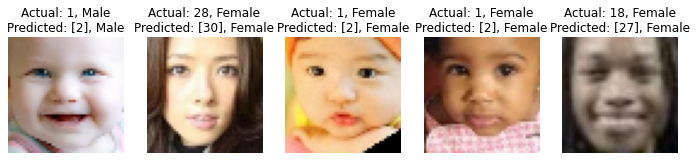

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Select random test images
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)

# Predict
predicted_ages, predicted_genders = model.predict(X_test[indices])

# Round predictions
rounded_ages = np.round(predicted_ages).astype(int)
predicted_genders = ["Female" if g > 0.5 else "Male" for g in predicted_genders.flatten()]

# Plot results
plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"Actual: {y_age_test[idx]}, {['Male', 'Female'][y_gender_test[idx]]}\n"
              f"Predicted: {rounded_ages[i]}, {predicted_genders[i]}")
plt.show()


SAVE THE MODEL

In [12]:
model.save("age_gender_model.h5")
print("Model saved successfully!")

Model saved successfully!


Predict Age & Gender, and Restrict Entry

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


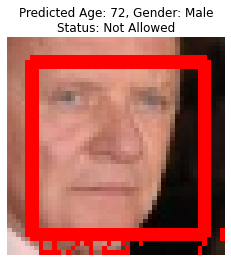

Entry logged successfully!


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import cv2  # For drawing rectangles
import os
from tensorflow.keras.models import load_model

# Load the trained model
def load_age_gender_model(model_path="age_gender_model.h5"):
   
    model = load_model(model_path, compile=False)
    model.compile(
        optimizer="adam",
        loss={"age_output": "mse", "gender_output": "binary_crossentropy"},
        metrics={"age_output": "mae", "gender_output": "accuracy"}
    )
    print("Model loaded successfully!")
    return model

# Function to predict age and gender, visualize, and log entry
def predict_and_log_entry(image_array, model, csv_file="horror_ride_entries.csv"):
   
    # Ensure the image has batch dimension
    sample_image = np.expand_dims(image_array, axis=0)  

    # Predict age and gender
    predicted_age, predicted_gender = model.predict(sample_image)

    # Process predictions
    predicted_age = int(np.round(predicted_age[0][0]))
    predicted_gender = "Female" if predicted_gender[0][0] > 0.5 else "Male"
    entry_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Set entry permission
    if predicted_age < 13 or predicted_age > 60:
        status = "Not Allowed"
        color = (255, 0, 0)  # Red
    else:
        status = "Allowed"
        color = (0, 255, 0)  # Green

    # Convert image for visualization
    image = (image_array * 255).astype("uint8")  # Convert to 0-255 range

    # Handle grayscale images
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB

    # Draw rectangle and text
    cv2.rectangle(image, (5, 5), (43, 43), color, 2)
    cv2.putText(image, f"Age: {predicted_age}, {predicted_gender}", (5, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    cv2.putText(image, status, (5, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Age: {predicted_age}, Gender: {predicted_gender}\nStatus: {status}")
    plt.show()

    # Log data into CSV
    new_entry = pd.DataFrame([[predicted_age, predicted_gender, entry_time, status]],
                             columns=["Age", "Gender", "Entry Time", "Status"])

    # Ensure CSV file exists with headers
    if not os.path.exists(csv_file):
        new_entry.to_csv(csv_file, index=False)
    else:
        new_entry.to_csv(csv_file, mode="a", header=False, index=False)

    print("Entry logged successfully!")

# Load the model
model = load_age_gender_model()

# Example usage with X_test (replace with actual image)
idx = np.random.randint(0, len(X_test))
predict_and_log_entry(X_test[idx], model)


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


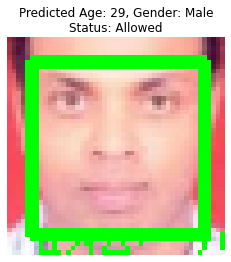

Entry logged successfully!


In [20]:
model = load_age_gender_model()

# Example usage with X_test (replace with actual image)
idx = np.random.randint(0, len(X_test))
predict_and_log_entry(X_test[idx], model)


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


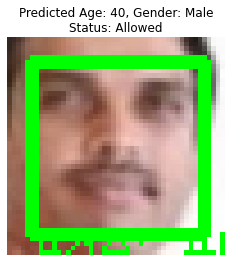

Entry logged successfully!


In [21]:
model = load_age_gender_model()

# Example usage with X_test (replace with actual image)
idx = np.random.randint(0, len(X_test))
predict_and_log_entry(X_test[idx], model)


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


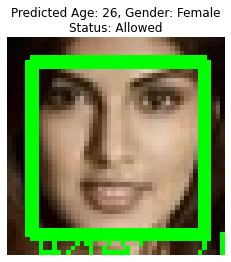

Entry logged successfully!


In [22]:
model = load_age_gender_model()

# Example usage with X_test (replace with actual image)
idx = np.random.randint(0, len(X_test))
predict_and_log_entry(X_test[idx], model)
